In [1]:
import sys
import logging
import pickle

import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from figure8_env import MyEnv as figure8_env
from figure8_alt1 import MyEnv as figure8_alt1
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

In [2]:
figure8_give_rewards = True
nn_yaml = 'network_noconv.yaml'
higher_dim_obs = False
internal_dim = 10
fname = 'figure8_alt1_mb_start'
set_network = ['mf_and_mb_1', 50, True]

In [3]:
class Defaults:
    # ----------------------
    # Setup Parameters (copied for convenience)
    # ----------------------
    figure8_give_rewards = figure8_give_rewards
    nn_yaml = nn_yaml
    higher_dim_obs = higher_dim_obs
    internal_dim = internal_dim
    fname = fname
    
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 5000
    epochs = 50
    steps_per_test = 1000
    period_btw_summary_perfs = 1

    # ----------------------
    # Temporal Processing Parameters
    # ----------------------
    nstep = 15
    nstep_decay = 0.8
    encoder_type = 'regular'
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2
    show_rewards = False

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    learning_rate = 1*1E-4
    learning_rate_decay = 1.0
    discount = 0.9
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 1000
    update_frequency = 10 #1
    replay_memory_size = 100000 #50000
    batch_size = 64
    freeze_interval = 1000
    deterministic = False
    
    # ----------------------
    # Learning algo parameters
    # ----------------------
    # T, entropy_neighbor, entropy_random, volume, gamma, R, Q, variational
    #loss_weights = [5E-3, 1E-3, 5E-3, 5E-3, 5E-3, 5E-3, 1.]
    #loss_weights = [0., 0., 0., 0., 0., 0., 1., 2E-4]
    loss_weights = [0, 0, 0, 0, 0, 0, 1., 0.]
    #loss_weights = [5E-3, 1E-2, 1E-2, 0, 0, 1E-2, 1., 0]

In [4]:
parameters = Defaults()
with open(f'params/{fname}.p', 'wb') as f:
    pickle.dump(parameters, f)

In [5]:
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

# --- Instantiate environment ---
env = figure8_alt1(
    give_rewards=figure8_give_rewards,
    intern_dim=internal_dim,
    higher_dim_obs=higher_dim_obs,
    show_rewards=parameters.show_rewards,
    nstep=parameters.nstep, nstep_decay=parameters.nstep_decay
    )

# --- Instantiate learning_algo ---
learning_algo = CRAR(
    env,
    parameters.freeze_interval,
    parameters.batch_size,
    rng,
    high_int_dim=False,
    internal_dim=internal_dim, lr=parameters.learning_rate,
    nn_yaml=nn_yaml, double_Q=True,
    loss_weights=parameters.loss_weights,
    nstep=parameters.nstep, nstep_decay=parameters.nstep_decay,
    encoder_type=parameters.encoder_type
    )

if figure8_give_rewards:
    train_policy = EpsilonGreedyPolicy(
        learning_algo, env.nActions(), rng, 0.2,
        consider_valid_transitions=False
        )
    test_policy = EpsilonGreedyPolicy(
        learning_algo, env.nActions(), rng, 0.
        )
else:
    train_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng, epsilon=0.2,
        height=env.HEIGHT, width=env.WIDTH
        )
    test_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng,
        height=env.HEIGHT, width=env.WIDTH
        )

# --- Instantiate agent ---
agent = NeuralAgent(
    env, learning_algo,
    parameters.replay_memory_size,
    1, parameters.batch_size, rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )

agent.run(10, 500)
print("end gathering data")

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# Learning rate may follow a scheduler
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=figure8_env.VALIDATION_MODE,
    testID=None,
    unique_fname=fname, savefrequency=5))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch. For each validation epoch, we want also to display the sum of all 
# rewards obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env 
# every [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=figure8_env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1,
    unique_fname=fname))

end gathering data


In [6]:
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
#agent.gathering_data=False
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters.epochs, parameters.steps_per_epoch)

# --- Show results ---
basename = "scores/" + fname
scores = load(basename + "_scores.jldump")
print(scores)

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.8411, -0.5356,  0.8122, -0.5220,  1.5794, -0.0450, -0.9167, -0.5140,
        -0.5469, -0.6832]) tensor([-0.4189,  0.0212,  0.0724, -1.1382,  1.1499,  0.1713, -1.0940, -0.7156,
        -0.3650,  0.0696]) tensor([-0.7207, -0.6223,  0.8142, -0.5251,  1.6582,  0.0586, -1.0050, -0.4947,
        -0.5328, -0.7241])
R[0]
tensor([0.0085], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09690992169082165; R = 0.007890252000070177;                 Gamma = 0.5649997182488441; Q = 0.015249120499938727;
Entropy Neighbor = 0.48469842475652697;                 Entropy Random = 0.05907760617882013;                 Volume = 2.7411421444416044; VAE = 0.0
Average (on the epoch) training loss: 0.015249120499938727
Episode average V value: 0.18107818946167828
epoch 1:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2


/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.9882,  0.6024, -0.5637, -1.1056,  0.2036, -0.4772, -0.5010, -0.9184,
        -0.4222, -0.2909]) tensor([-0.9339,  0.5436, -0.4156, -0.9368,  0.6235, -0.4868, -0.7692, -1.0243,
        -0.2210, -0.4491]) tensor([-1.7453,  0.5367, -0.6017, -0.5731, -0.3399, -1.1536,  0.4147, -0.7051,
        -0.5685, -0.9094])
R[0]
tensor([-0.0036], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09645513741672039; R = 0.009669134304713225;                 Gamma = 0.5746465259790421; Q = 0.012629904050845653;
Entropy Neighbor = 0.4301225872039795;                 Entropy Random = 0.03202665254182648;                 Volume = 2.3523463773727418; VAE = 0.0
Average (on the epoch) training loss: 0.012629904050845653
Episode average V value: 0.13674089485555888
epoch 2:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.7887,  1.4839,  0.3547, -0.0760, -0.0019, -0.6055, -0.4454, -0.9291,
         0.3914,  0.7474]) tensor([-0.4244,  0.9911,  0.4003,  0.0677,  0.2567, -0.3911, -0.7061, -0.7085,
         0.1934,  0.1581]) tensor([-0.8234,  1.4732,  0.3793, -0.0389,  0.0018, -0.6309, -0.4182, -0.9234,
         0.3937,  0.7343])
R[0]
tensor([-0.0409], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09909571439027787; R = 0.01608444248174783;                 Gamma = 0.581302687883377; Q = 0.003803348617744632;
Entropy Neighbor = 0.40496230906248093;                 Entropy Random = 0.02033686840775772;                 Volume = 1.993375949382782; VAE = 0.0
Average (on the epoch) training loss: 0.003803348617744632
Episode average V value: 0.14803500997200608
epoch 3:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 e

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1020,  1.3544, -0.8189, -1.8283, -0.2822,  0.8926, -0.9975, -0.5927,
         0.1677,  1.6204]) tensor([ 1.3772,  1.2472, -0.9178, -1.8423,  0.3729,  0.9365, -1.6902, -0.8428,
         0.2939,  1.3848]) tensor([ 0.8607,  1.4780, -0.6327, -1.6263, -0.2654,  0.6699, -0.9973, -0.6664,
         0.0952,  1.5109])
R[0]
tensor([-0.0174], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09791200543940068; R = 0.016574756609392352;                 Gamma = 0.5835143008232117; Q = 0.003711625766241923;
Entropy Neighbor = 0.39669151306152345;                 Entropy Random = 0.01684904836205533;                 Volume = 1.9198656215667724; VAE = 0.0
Average (on the epoch) training loss: 0.003711625766241923
Episode average V value: 0.14250123179714236
epoch 4:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 2.1673, -0.6319, -1.7263, -2.6725,  0.5435,  2.2800, -1.7645, -0.2555,
        -0.3187,  0.7255]) tensor([ 1.6729, -0.5659, -1.5670, -2.4061,  0.3560,  1.9080, -1.4133, -0.2387,
        -0.3463,  0.6151]) tensor([ 2.1673, -0.6319, -1.7263, -2.6725,  0.5435,  2.2800, -1.7645, -0.2555,
        -0.3187,  0.7255])
R[0]
tensor([-0.0011], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10085844931006431; R = 0.016692580757662653;                 Gamma = 0.5863274229764939; Q = 0.004071034215623513;
Entropy Neighbor = 0.38310353565216065;                 Entropy Random = 0.015382181657769252;                 Volume = 1.8682345905303954; VAE = 0.0
Average (on the epoch) training loss: 0.004071034215623513
Episode average V value: 0.14687711147918991
epoch 5:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1961, -0.3868,  1.4480,  0.3930,  1.4540,  0.2926, -0.6544, -0.0443,
         0.0610, -0.5969]) tensor([-0.4765, -0.5544,  1.4859,  0.3288,  1.4930,  0.1203, -0.4397,  0.0134,
        -0.1669, -0.8336]) tensor([ 0.1749, -0.3422,  1.0172, -0.0351,  1.3562,  0.5136, -0.6581, -0.0384,
         0.1265, -0.3439])
R[0]
tensor([0.0006], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10426921686530113; R = 0.016592965688440018;                 Gamma = 0.5856808903217315; Q = 0.004711788074229844;
Entropy Neighbor = 0.3726034319996834;                 Entropy Random = 0.013458452996215783;                 Volume = 1.7201459367275238; VAE = 0.0
Average (on the epoch) training loss: 0.004711788074229844
Episode average V value: 0.18439998742043973
epoch 6:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.7582,  1.0495, -0.5417, -1.5595, -0.2592,  0.7916, -1.1242, -0.5728,
        -0.3787,  1.2120]) tensor([ 0.6401,  0.7778, -0.3613, -1.5250,  0.3289,  0.6825, -1.3064, -0.6439,
        -0.3824,  0.7586]) tensor([-0.3382,  0.6261, -0.1741, -1.1311,  0.6875,  0.0772, -1.1526, -0.9124,
        -0.3042,  0.4382])
R[0]
tensor([-0.0176], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10473413380980491; R = 0.017210875957855025;                 Gamma = 0.585601776599884; Q = 0.004528420182119589;
Entropy Neighbor = 0.3796289240121841;                 Entropy Random = 0.01502418669796316;                 Volume = 1.6386168367862701; VAE = 0.0
Average (on the epoch) training loss: 0.004528420182119589
Episode average V value: 0.1661102380391168
epoch 7:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 e

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.6398,  0.9914,  0.8935,  0.2972,  0.2643, -0.2687, -0.5778, -0.6532,
         0.2687,  0.7940]) tensor([-0.7695,  0.7848,  0.9136,  0.2854,  0.7205, -0.4337, -0.7155, -0.7410,
         0.2468,  0.3454]) tensor([-0.6398,  0.9914,  0.8935,  0.2972,  0.2643, -0.2687, -0.5778, -0.6532,
         0.2687,  0.7940])
R[0]
tensor([-0.0111], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10627975621819497; R = 0.017156670102500358;                 Gamma = 0.5844535685777664; Q = 0.004395844264188781;
Entropy Neighbor = 0.37781322467327116;                 Entropy Random = 0.015310524159052876;                 Volume = 1.6032894124984742; VAE = 0.0
Average (on the epoch) training loss: 0.004395844264188781
Episode average V value: 0.19460094106346368
epoch 8:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.8307, -0.0647, -1.5551, -2.5226,  0.3898,  1.8171, -1.4396, -0.3625,
        -0.1516,  0.9621]) tensor([ 1.3415, -0.1450, -1.1358, -2.0532,  0.4841,  1.4745, -1.2336, -0.3309,
        -0.1395,  0.6790]) tensor([ 1.8956, -0.1770, -1.6541, -2.6285,  0.3981,  1.9190, -1.4914, -0.3489,
        -0.1992,  0.9555])
R[0]
tensor([0.0088], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10431993100047111; R = 0.016617061308119446;                 Gamma = 0.5853395862579346; Q = 0.0045259430794103534;
Entropy Neighbor = 0.3957931213974953;                 Entropy Random = 0.018522846412961372;                 Volume = 1.5764727902412414; VAE = 0.0
Average (on the epoch) training loss: 0.0045259430794103534
Episode average V value: 0.16289462070018054
epoch 9:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.3609,  1.3053, -0.2551, -1.2957, -0.0513,  0.3679, -1.0144, -0.7211,
        -0.2048,  1.1482]) tensor([ 0.1975,  0.8976, -0.0920, -1.3253,  0.5012,  0.2628, -1.1005, -0.7157,
        -0.3525,  0.5803]) tensor([ 0.4794,  1.3246, -0.3472, -1.3977, -0.1607,  0.4438, -0.9876, -0.6742,
        -0.2698,  1.2064])
R[0]
tensor([0.3081], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10598227414488792; R = 0.014928694696398452;                 Gamma = 0.5849713233709335; Q = 0.0039218595083220864;
Entropy Neighbor = 0.40058878368139267;                 Entropy Random = 0.020334514772053808;                 Volume = 1.503046302318573; VAE = 0.0
Average (on the epoch) training loss: 0.0039218595083220864
Episode average V value: 0.16820099253813298
epoch 10:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8142,  0.9794, -0.5287, -1.4649,  0.0204,  0.6752, -0.6809, -0.4550,
         0.1385,  1.1275]) tensor([ 0.5706,  0.4822, -0.3391, -1.5376,  0.5312,  0.5453, -0.6570, -0.3855,
        -0.1228,  0.4841]) tensor([ 0.7043,  0.1712,  0.0855, -0.9011,  0.7177,  0.7296, -0.5572, -0.1335,
         0.1314,  0.3620])
R[0]
tensor([-0.0346], grad_fn=<SelectBackward0>)
LOSSES
T = 0.1061186401695013; R = 0.015965414627455175;                 Gamma = 0.5877443599700928; Q = 0.004213053957239026;
Entropy Neighbor = 0.4048924200534821;                 Entropy Random = 0.021706858374993317;                 Volume = 1.5343858695030212; VAE = 0.0
Average (on the epoch) training loss: 0.004213053957239026
Episode average V value: 0.15415845387727023
epoch 11:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.3654,  0.8785, -1.1480, -2.1877, -0.0734,  1.2280, -0.9909, -0.4746,
         0.1940,  1.6606]) tensor([ 1.1142,  0.6080, -0.8350, -2.0003,  0.3977,  1.0496, -1.0497, -0.4862,
         0.1584,  1.2090]) tensor([ 1.0524,  1.1552, -0.9356, -1.9676, -0.1147,  0.9252, -0.9413, -0.5927,
         0.2484,  1.6967])
R[0]
tensor([0.0144], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10775073547661304; R = 0.0165502899591811;                 Gamma = 0.5864985731840133; Q = 0.00481758834028733;
Entropy Neighbor = 0.4133193435072899;                 Entropy Random = 0.024485880607855507;                 Volume = 1.4999377706050874; VAE = 0.0
Average (on the epoch) training loss: 0.00481758834028733
Episode average V value: 0.15612391946837306
epoch 12:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 ep

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8642,  0.5772, -0.0492, -0.9732,  0.1535,  1.0064, -1.0190, -0.3641,
         0.2089,  1.3796]) tensor([ 0.6637,  0.0692,  0.0965, -1.1096,  0.6980,  0.9056, -1.0247, -0.3063,
        -0.0525,  0.7365]) tensor([ 0.6864,  0.5123, -0.0042, -0.9367,  0.1159,  0.9446, -0.9138, -0.3478,
         0.1910,  1.4578])
R[0]
tensor([0.0168], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10974259792268276; R = 0.013889708609320223;                 Gamma = 0.5868968688249588; Q = 0.004165586811490357;
Entropy Neighbor = 0.4233824122548103;                 Entropy Random = 0.026630839095218108;                 Volume = 1.5616907222270966; VAE = 0.0
Average (on the epoch) training loss: 0.004165586811490357
Episode average V value: 0.15820484644025565
epoch 13:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.2929, -0.6113,  0.0700, -0.5826,  1.2959,  0.7254, -0.5340, -0.1977,
         0.4637,  0.1984]) tensor([ 0.2114, -0.3538, -0.0665, -0.6485,  1.0944,  0.6028, -0.4370, -0.2653,
         0.5068,  0.4254]) tensor([ 0.3076, -0.6191,  0.0908, -0.5669,  1.2800,  0.7447, -0.5389, -0.1831,
         0.4541,  0.2053])
R[0]
tensor([0.0077], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10882587321102619; R = 0.013034572575706989;                 Gamma = 0.5872995153665542; Q = 0.0041346566884894855;
Entropy Neighbor = 0.4221164146065712;                 Entropy Random = 0.028329220194835216;                 Volume = 1.553104266166687; VAE = 0.0
Average (on the epoch) training loss: 0.0041346566884894855
Episode average V value: 0.16270139364525676
epoch 14:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:293: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  abs_states[i:i+1], torch.as_tensor([action_encoding])
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.3720,  1.1477,  0.0840, -0.7251, -0.2462,  0.4356, -0.7333, -0.4772,
         0.0293,  1.3002]) tensor([ 0.1702,  0.6493,  0.2115, -0.8508,  0.2825,  0.3153, -0.7384, -0.4207,
        -0.2388,  0.6323]) tensor([ 0.3613,  1.1701,  0.0894, -0.7158, -0.2575,  0.4243, -0.7528, -0.4906,
         0.0180,  1.2865])
R[0]
tensor([-0.0822], grad_fn=<SelectBackward0>)
LOSSES
T = 0.11070460431277752; R = 0.012394764302065596;                 Gamma = 0.5879980664253235; Q = 0.0047468636143603365;
Entropy Neighbor = 0.4125564393401146;                 Entropy Random = 0.026969829195179044;                 Volume = 1.6090502526760102; VAE = 0.0
Average (on the epoch) training loss: 0.0047468636143603365
Episode average V value: 0.15040587480291726
epoch 15:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ov

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.6186,  1.1160, -0.0736, -0.9729, -0.2298,  0.6136, -0.7578, -0.4296,
         0.0450,  1.4293]) tensor([ 0.3934,  0.6014,  0.0773, -1.0879,  0.2976,  0.4879, -0.7464, -0.3628,
        -0.2355,  0.7553]) tensor([ 0.5907,  1.1490, -0.0640, -0.9461, -0.2649,  0.5869, -0.7679, -0.4419,
         0.0203,  1.4057])
R[0]
tensor([-0.0590], grad_fn=<SelectBackward0>)
LOSSES
T = 0.11010454845428466; R = 0.011340383524773642;                 Gamma = 0.5883759181499482; Q = 0.004321486021770397;
Entropy Neighbor = 0.41221300488710405;                 Entropy Random = 0.02663214348233305;                 Volume = 1.5573447036743164; VAE = 0.0
Average (on the epoch) training loss: 0.004321486021770397
Episode average V value: 0.16697525801474297
epoch 16:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.5968,  1.0523, -0.0044, -0.8826, -0.2196,  0.6258, -0.7619, -0.4026,
         0.0282,  1.3792]) tensor([ 0.4042,  0.7697,  0.1706, -0.8219,  0.3010,  0.4602, -0.8760, -0.4519,
        -0.0243,  0.8857]) tensor([ 0.5918,  1.0885, -0.0110, -0.8866, -0.2403,  0.6118, -0.7759, -0.4169,
         0.0157,  1.3719])
R[0]
tensor([-0.0165], grad_fn=<SelectBackward0>)
LOSSES
T = 0.11003764207661151; R = 0.011089824222959578;                 Gamma = 0.588270637512207; Q = 0.003946105147129856;
Entropy Neighbor = 0.41058841955661773;                 Entropy Random = 0.02732103727152571;                 Volume = 1.5854748923778534; VAE = 0.0
Average (on the epoch) training loss: 0.003946105147129856
Episode average V value: 0.15206529346480965
epoch 17:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.6103,  0.6268,  0.3817, -0.6092,  0.4848,  0.6443, -1.0635, -0.3779,
        -0.0246,  0.5142]) tensor([ 0.3313,  0.1834,  0.5776, -0.6361,  0.9195,  0.4908, -0.9930, -0.3103,
        -0.2628, -0.0706]) tensor([ 0.5432,  0.6296,  0.4376, -0.5360,  0.4647,  0.6124, -1.0466, -0.3797,
         0.0084,  0.4955])
R[0]
tensor([-0.0364], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10930375503003598; R = 0.01190752210933715;                 Gamma = 0.5876709983348847; Q = 0.004192769202112686;
Entropy Neighbor = 0.4108744748234749;                 Entropy Random = 0.026227322360500693;                 Volume = 1.5557724571228027; VAE = 0.0
Average (on the epoch) training loss: 0.004192769202112686
Episode average V value: 0.15571034572869538
epoch 18:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.3033,  0.0909, -0.6607, -1.5557,  0.1996,  1.4705, -0.9580, -0.2037,
         0.1958,  1.4361]) tensor([ 0.9885, -0.1838, -0.3083, -1.3195,  0.6000,  1.2614, -0.9418, -0.1839,
         0.1327,  0.9847]) tensor([ 1.0949, -0.1634, -0.2188, -1.0646,  0.5787,  1.3780, -1.1504, -0.2487,
         0.2121,  1.1225])
R[0]
tensor([0.0117], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10722094343602658; R = 0.012722664672182873;                 Gamma = 0.5882344402074814; Q = 0.004045637474249816;
Entropy Neighbor = 0.40894962722063066;                 Entropy Random = 0.023680274879559874;                 Volume = 1.5727296953201293; VAE = 0.0
Average (on the epoch) training loss: 0.004045637474249816
Episode average V value: 0.1493801899023354
epoch 19:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.6109,  1.2276, -0.8280, -1.7963, -0.2186,  0.4730, -0.5887, -0.6003,
        -0.0260,  1.1901]) tensor([ 0.9066,  1.0085, -0.7345, -1.6972,  0.4635,  0.6013, -1.3079, -0.7715,
         0.0525,  0.9620]) tensor([ 0.2605,  1.2944, -0.5382, -1.4745, -0.1254,  0.2161, -0.6381, -0.7020,
        -0.0538,  1.0181])
R[0]
tensor([-0.0341], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10810838405787945; R = 0.014412033586530015;                 Gamma = 0.5893891808986664; Q = 0.004193071453133598;
Entropy Neighbor = 0.4023552569746971;                 Entropy Random = 0.023113698748638854;                 Volume = 1.5389278509616853; VAE = 0.0
Average (on the epoch) training loss: 0.004193071453133598
Episode average V value: 0.1529478069126606
epoch 20:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.3400,  1.0901, -0.2590, -1.2260,  0.2902,  0.3365, -0.7510, -0.6856,
         0.2455,  1.3771]) tensor([ 0.2363,  0.6683, -0.1544, -1.3470,  0.7922,  0.2683, -0.7953, -0.6455,
         0.0512,  0.7966]) tensor([ 0.8106,  0.7363, -0.6218, -1.6084,  0.2831,  0.8075, -0.8787, -0.5367,
         0.1585,  1.3628])
R[0]
tensor([0.0564], grad_fn=<SelectBackward0>)
LOSSES
T = 0.1085060947984457; R = 0.016911691502900793;                 Gamma = 0.5908006472587586; Q = 0.004673369570838986;
Entropy Neighbor = 0.3950994192361832;                 Entropy Random = 0.023963849543128163;                 Volume = 1.5357000665664673; VAE = 0.0
Average (on the epoch) training loss: 0.004673369570838986
Episode average V value: 0.15206117038205266
epoch 21:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.5604,  1.2412, -0.4760, -1.5742, -0.0793,  0.4525, -0.8347, -0.5978,
        -0.2649,  1.0144]) tensor([ 0.3924,  1.0073, -0.2618, -1.4646,  0.4553,  0.3032, -0.9839, -0.6676,
        -0.2528,  0.5821]) tensor([ 0.5918,  1.4185, -0.5275, -1.5786, -0.2221,  0.4428, -0.8505, -0.6544,
        -0.1744,  1.2185])
R[0]
tensor([-0.0383], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10654948788881302; R = 0.019587835013167933;                 Gamma = 0.5911949931383133; Q = 0.004561584531067637;
Entropy Neighbor = 0.3900221931934357;                 Entropy Random = 0.02274680416821502;                 Volume = 1.5250017080307008; VAE = 0.0
Average (on the epoch) training loss: 0.004561584531067637
Episode average V value: 0.14959366788823478
epoch 22:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.6715, -0.6282, -1.0848, -2.0529,  0.9316,  1.8164, -1.4349, -0.2259,
        -0.1251,  0.5659]) tensor([ 1.4137, -0.6107, -1.0167, -1.9850,  0.9794,  1.6075, -1.3048, -0.2634,
        -0.1515,  0.4666]) tensor([ 1.6897, -0.6250, -1.1001, -2.0607,  0.9302,  1.8247, -1.4396, -0.2271,
        -0.1187,  0.5670])
R[0]
tensor([0.0390], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10501976957917214; R = 0.021263216318795457;                 Gamma = 0.5921808580160141; Q = 0.003587461688570329;
Entropy Neighbor = 0.3861238794922829;                 Entropy Random = 0.023728118611034008;                 Volume = 1.5835454835891725; VAE = 0.0
Average (on the epoch) training loss: 0.003587461688570329
Episode average V value: 0.1452368321882758
epoch 23:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.7777,  1.1725, -0.6115, -1.7066, -0.1081,  0.5988, -0.6769, -0.4908,
        -0.1563,  1.2993]) tensor([ 1.0695,  1.0168, -0.6426, -1.6853,  0.5620,  0.6888, -1.3653, -0.7083,
        -0.0355,  1.0669]) tensor([ 0.6430,  1.2134, -0.5939, -1.6403, -0.3249,  0.5284, -0.6120, -0.4745,
        -0.3115,  1.2576])
R[0]
tensor([-0.0391], grad_fn=<SelectBackward0>)
LOSSES
T = 0.1042545520812273; R = 0.023870659080566837;                 Gamma = 0.5936976829767228; Q = 0.0035529194434348026;
Entropy Neighbor = 0.384352213293314;                 Entropy Random = 0.02300440673576668;                 Volume = 1.609791930437088; VAE = 0.0
Average (on the epoch) training loss: 0.0035529194434348026
Episode average V value: 0.13862419138625265
epoch 24:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.9852,  1.1489, -0.3744, -1.3676, -0.3081,  0.8820, -0.8978, -0.4106,
         0.0171,  1.5399]) tensor([ 0.7691,  0.8347, -0.1605, -1.2927,  0.2086,  0.7170, -0.9839, -0.4358,
        -0.0616,  1.0289]) tensor([ 0.9852,  1.1489, -0.3744, -1.3676, -0.3081,  0.8820, -0.8978, -0.4106,
         0.0171,  1.5399])
R[0]
tensor([-0.0069], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10156213828921318; R = 0.021754030964337288;                 Gamma = 0.594676963686943; Q = 0.0032047744922456332;
Entropy Neighbor = 0.37661482948064806;                 Entropy Random = 0.022640413804911077;                 Volume = 1.600771062374115; VAE = 0.0
Average (on the epoch) training loss: 0.0032047744922456332
Episode average V value: 0.1339371598303318
epoch 25:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.3730,  1.1124, -0.1702, -1.2093,  0.1104,  0.3521, -0.8565, -0.5994,
        -0.1703,  0.8246]) tensor([ 0.1497,  0.6539,  0.0209, -1.2550,  0.6333,  0.2268, -0.8683, -0.5543,
        -0.3846,  0.2163]) tensor([ 0.5738,  0.9427, -0.0764, -1.0721,  0.1598,  0.5370, -0.8853, -0.4819,
        -0.0702,  0.7816])
R[0]
tensor([-0.0435], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10137053517997265; R = 0.022152147118467837;                 Gamma = 0.5950680962800979; Q = 0.003475842023806763;
Entropy Neighbor = 0.37323186367750166;                 Entropy Random = 0.02130663737561554;                 Volume = 1.5599507398605346; VAE = 0.0
Average (on the epoch) training loss: 0.003475842023806763
Episode average V value: 0.13960775434300304
epoch 26:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.3778,  0.9742, -0.3550, -1.3363,  0.2250,  0.3764, -0.8422, -0.6271,
        -0.1008,  0.7248]) tensor([ 0.1743,  0.5442, -0.1724, -1.3788,  0.7380,  0.2616, -0.8640, -0.5920,
        -0.2874,  0.1517]) tensor([ 0.5636,  0.8846, -0.1819, -1.1532,  0.2170,  0.5452, -0.8759, -0.5055,
        -0.0138,  0.7638])
R[0]
tensor([-0.0230], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09952101561427117; R = 0.017994579029269517;                 Gamma = 0.5973272732496262; Q = 0.002865794052457204;
Entropy Neighbor = 0.3721126862168312;                 Entropy Random = 0.022457511799177154;                 Volume = 1.6103741171360015; VAE = 0.0
Average (on the epoch) training loss: 0.002865794052457204
Episode average V value: 0.13688920352143702
epoch 27:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1260,  1.0486, -0.5019, -1.5066, -0.2962,  1.0265, -0.9072, -0.3699,
         0.0768,  1.6161]) tensor([ 0.8874,  0.7095, -0.2602, -1.4214,  0.2078,  0.8587, -0.9637, -0.3729,
        -0.0269,  1.0903]) tensor([ 1.1283,  1.0590, -0.5004, -1.5073, -0.3010,  1.0247, -0.9160, -0.3734,
         0.0672,  1.6103])
R[0]
tensor([0.0026], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0982509905397892; R = 0.01770616808766499;                 Gamma = 0.5977084257602692; Q = 0.0028395587615523254;
Entropy Neighbor = 0.36924270379543306;                 Entropy Random = 0.02062284638779238;                 Volume = 1.5559883580207825; VAE = 0.0
Average (on the epoch) training loss: 0.0028395587615523254
Episode average V value: 0.13392954613833058
epoch 28:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.5112,  1.4026, -0.5806, -1.6569, -0.1860,  0.3717, -0.8399, -0.6814,
        -0.2993,  1.1067]) tensor([ 0.0186,  1.6845, -0.6877, -1.2631,  0.0675, -0.2823, -1.0475, -1.0695,
        -0.1083,  0.7601]) tensor([ 0.3931,  1.4236, -0.5873, -1.5948, -0.2356,  0.2552, -0.7086, -0.6888,
        -0.2615,  1.0293])
R[0]
tensor([0.1193], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09558551128208637; R = 0.014917300423141568;                 Gamma = 0.598262634754181; Q = 0.0026535207907436415;
Entropy Neighbor = 0.36567744636535643;                 Entropy Random = 0.020181366039440037;                 Volume = 1.5889297165870666; VAE = 0.0
Average (on the epoch) training loss: 0.0026535207907436415
Episode average V value: 0.13424439711123706
epoch 29:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.0282,  0.9471, -0.3764, -1.3288, -0.0567,  0.8956, -0.9139, -0.3902,
         0.1112,  1.1185]) tensor([ 0.7687,  0.4070, -0.1880, -1.4261,  0.4607,  0.7655, -0.8694, -0.3034,
        -0.1905,  0.4379]) tensor([ 1.0450,  0.9259, -0.3091, -1.2714, -0.0279,  0.9122, -0.9588, -0.3777,
         0.0838,  1.0702])
R[0]
tensor([-0.0188], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09536121520400047; R = 0.01431384231732227;                 Gamma = 0.5976391509771347; Q = 0.00252111830447393;
Entropy Neighbor = 0.3662497779726982;                 Entropy Random = 0.02163178341416642;                 Volume = 1.5464706683158875; VAE = 0.0
Average (on the epoch) training loss: 0.00252111830447393
Episode average V value: 0.12382030883729458
epoch 30:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 e

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.7845, -0.6168, -1.2644, -2.2139,  0.9760,  1.8544, -1.4676, -0.2554,
        -0.1424,  0.5621]) tensor([ 1.5129, -0.5900, -1.1923, -2.1350,  1.0138,  1.6349, -1.3289, -0.2957,
        -0.1640,  0.4678]) tensor([ 1.7647, -0.6088, -1.2601, -2.2309,  0.9714,  1.8418, -1.4580, -0.2539,
        -0.1614,  0.5591])
R[0]
tensor([0.0403], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0938918215483427; R = 0.014310865961015225;                 Gamma = 0.5982235984802247; Q = 0.002808627388352761;
Entropy Neighbor = 0.3635669575035572;                 Entropy Random = 0.022596644673496483;                 Volume = 1.5890771358013154; VAE = 0.0
Average (on the epoch) training loss: 0.002808627388352761
Episode average V value: 0.117971785774827
epoch 31:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 e

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.4856,  0.4035, -0.0776, -1.0654,  0.6217,  0.6176, -1.0336, -0.4747,
        -0.2128,  0.3825]) tensor([ 0.2292,  0.1739,  0.1154, -0.9749,  0.9530,  0.4398, -0.9928, -0.4757,
        -0.2853, -0.0011]) tensor([ 0.9162,  1.0627, -0.4965, -1.5401, -0.0871,  0.8081, -1.0313, -0.5131,
        -0.1709,  1.1800])
R[0]
tensor([-0.0223], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09288833798468113; R = 0.014918596853967757;                 Gamma = 0.5981551488637924; Q = 0.002446925330659724;
Entropy Neighbor = 0.3610497305393219;                 Entropy Random = 0.02425030696950853;                 Volume = 1.5433630919456482; VAE = 0.0
Average (on the epoch) training loss: 0.002446925330659724
Episode average V value: 0.1135348635143484
epoch 32:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8716,  0.7636, -0.3174, -1.2961,  0.1891,  0.8102, -0.9320, -0.4061,
         0.0459,  0.8134]) tensor([ 0.6221,  0.2725, -0.1279, -1.3666,  0.6918,  0.6796, -0.9003, -0.3383,
        -0.2112,  0.1822]) tensor([ 0.8602,  0.9581, -0.3354, -1.3224, -0.0349,  0.7651, -0.8458, -0.4075,
         0.0343,  1.0019])
R[0]
tensor([-0.0167], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09135784161090851; R = 0.01583729018084705;                 Gamma = 0.5989729208946228; Q = 0.002310636845752015;
Entropy Neighbor = 0.3635003700256348;                 Entropy Random = 0.026112392062321306;                 Volume = 1.573442786216736; VAE = 0.0
Average (on the epoch) training loss: 0.002310636845752015
Episode average V value: 0.10817929845973849
epoch 33:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.9042,  0.8244, -0.0130, -1.0468,  0.0525,  0.8454, -1.0194, -0.3247,
        -0.1305,  0.7751]) tensor([ 0.5950,  0.6502,  0.0235, -0.9500,  0.4597,  0.5358, -1.0798, -0.4431,
        -0.1769,  0.2699]) tensor([ 0.9042,  0.8244, -0.0130, -1.0468,  0.0525,  0.8454, -1.0194, -0.3247,
        -0.1305,  0.7751])
R[0]
tensor([-0.3782], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09081766432523727; R = 0.01764254785887897;                 Gamma = 0.5992144109010696; Q = 0.0020970720885525223;
Entropy Neighbor = 0.36405654579401014;                 Entropy Random = 0.028165753525681795;                 Volume = 1.5260888621807098; VAE = 0.0
Average (on the epoch) training loss: 0.0020970720885525223
Episode average V value: 0.11546850684232104
epoch 34:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ov

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8312,  1.2557, -0.8645, -1.9115, -0.2453,  0.6481, -0.7364, -0.5683,
        -0.0928,  1.3151]) tensor([ 1.1631,  1.0555, -0.8316, -1.8574,  0.4718,  0.7891, -1.4626, -0.7645,
         0.0296,  1.0788]) tensor([ 0.5564,  1.3561, -0.6488, -1.6758, -0.2240,  0.4238, -0.7457, -0.6471,
        -0.1452,  1.1831])
R[0]
tensor([-0.0323], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09004903176426887; R = 0.017953677309677004;                 Gamma = 0.60007275390625; Q = 0.001682770482795604;
Entropy Neighbor = 0.37434371915459635;                 Entropy Random = 0.032136857345700265;                 Volume = 1.576479590177536; VAE = 0.0
Average (on the epoch) training loss: 0.001682770482795604
Episode average V value: 0.10553232902511954
epoch 35:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.5793,  0.6528, -1.1619, -2.2629,  0.3647,  0.5475, -0.6506, -0.5911,
        -0.2345,  0.5805]) tensor([ 0.9610,  0.3198, -0.8756, -2.1379,  1.0932,  0.8698, -1.3052, -0.6680,
        -0.1222,  0.4442]) tensor([ 0.2434,  1.0176, -1.1449, -2.1642,  0.1036,  0.1997, -0.5111, -0.7508,
        -0.2685,  0.6855])
R[0]
tensor([-0.0115], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0904196052402258; R = 0.01936935839895159;                 Gamma = 0.6002694222927093; Q = 0.0016640524954418651;
Entropy Neighbor = 0.37484168526530265;                 Entropy Random = 0.033728479695506394;                 Volume = 1.5487920410633087; VAE = 0.0
Average (on the epoch) training loss: 0.0016640524954418651
Episode average V value: 0.10300790112533434
epoch 36:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.0704,  0.9151, -0.1942, -1.2185, -0.0319,  0.9353, -1.0287, -0.3360,
        -0.0623,  0.9499]) tensor([ 0.7341,  0.7852, -0.1798, -1.0844,  0.3462,  0.5803, -1.0925, -0.4760,
        -0.0901,  0.4463]) tensor([ 1.0724,  0.8822, -0.1592, -1.1851, -0.0053,  0.9455, -1.0483, -0.3263,
        -0.0762,  0.9108])
R[0]
tensor([-0.3563], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09037728823721408; R = 0.019154588466510178;                 Gamma = 0.6007679814100265; Q = 0.0013598915482580195;
Entropy Neighbor = 0.3773155943751335;                 Entropy Random = 0.037871170671656726;                 Volume = 1.609502717256546; VAE = 0.0
Average (on the epoch) training loss: 0.0013598915482580195
Episode average V value: 0.09538363130688668
epoch 37:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8817,  0.5235, -0.9719, -2.0820,  0.5693,  0.7834, -0.9179, -0.5262,
        -0.2023,  0.5847]) tensor([ 0.5022,  0.5456, -0.7567, -1.7913,  0.7836,  0.4708, -0.8652, -0.6454,
        -0.1039,  0.3833]) tensor([ 1.1061,  0.3408, -1.2144, -2.3034,  0.6308,  1.0016, -0.9889, -0.4913,
        -0.1470,  0.5622])
R[0]
tensor([-0.1372], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09062153461575508; R = 0.021622756693512202;                 Gamma = 0.6008718237876892; Q = 0.0018268670426914468;
Entropy Neighbor = 0.37719069397449495;                 Entropy Random = 0.0402913613980636;                 Volume = 1.600275811433792; VAE = 0.0
Average (on the epoch) training loss: 0.0018268670426914468
Episode average V value: 0.09666601417064667
epoch 38:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1198,  0.8340, -0.1616, -1.1891,  0.0036,  0.9942, -1.0642, -0.2997,
        -0.0925,  0.8877]) tensor([ 0.8084,  0.6003, -0.0853, -1.1075,  0.4226,  0.7101, -1.0987, -0.3805,
        -0.1797,  0.3555]) tensor([ 1.1198,  0.8340, -0.1616, -1.1891,  0.0036,  0.9942, -1.0642, -0.2997,
        -0.0925,  0.8877])
R[0]
tensor([-0.3614], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09130733427405358; R = 0.020606929305940866;                 Gamma = 0.6006214315891266; Q = 0.0014593504669173853;
Entropy Neighbor = 0.3793217494487762;                 Entropy Random = 0.043421165153384206;                 Volume = 1.6453813195228577; VAE = 0.0
Average (on the epoch) training loss: 0.0014593504669173853
Episode average V value: 0.08915213962495327
epoch 39:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ov

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.8868,  0.6964, -1.0263, -2.1303,  0.3816,  0.7576, -0.8963, -0.5507,
        -0.2248,  0.7056]) tensor([ 0.6426,  0.6483, -0.8452, -1.9013,  0.7563,  0.5343, -0.9887, -0.6889,
        -0.1116,  0.4431]) tensor([ 1.0346,  0.4434, -1.1783, -2.2751,  0.5541,  0.9275, -0.9615, -0.5119,
        -0.1785,  0.5838])
R[0]
tensor([-0.0966], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09214918074011803; R = 0.021716901091858743;                 Gamma = 0.5996938735246659; Q = 0.0012361874515845557;
Entropy Neighbor = 0.3782096346616745;                 Entropy Random = 0.04671708441153169;                 Volume = 1.6301566874980926; VAE = 0.0
Average (on the epoch) training loss: 0.0012361874515845557
Episode average V value: 0.08972494543194771
epoch 40:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.2104,  0.9386, -0.5302, -1.5317, -0.1066,  1.0265, -0.9359, -0.3440,
         0.0616,  1.1495]) tensor([ 0.9421,  0.4068, -0.3270, -1.6084,  0.4066,  0.8904, -0.8897, -0.2583,
        -0.2321,  0.4761]) tensor([ 1.2349,  0.9809, -0.5508, -1.5472, -0.1702,  1.0410, -0.9240, -0.3411,
         0.0744,  1.2190])
R[0]
tensor([-0.0057], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09395179511606694; R = 0.020326529135927557;                 Gamma = 0.5995659427642822; Q = 0.001238748611860501;
Entropy Neighbor = 0.3747068384289742;                 Entropy Random = 0.05122586466558278;                 Volume = 1.6902212464809419; VAE = 0.0
Average (on the epoch) training loss: 0.001238748611860501
Episode average V value: 0.08455518311411142
epoch 41:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.2707,  0.8305, -0.2842, -1.3059, -0.0414,  1.1071, -1.0946, -0.2810,
        -0.0673,  0.9614]) tensor([ 0.9626,  0.5538, -0.1784, -1.2383,  0.3906,  0.8455, -1.1143, -0.3356,
        -0.1817,  0.4128]) tensor([ 1.2707,  0.8305, -0.2842, -1.3059, -0.0414,  1.1071, -1.0946, -0.2810,
        -0.0673,  0.9614])
R[0]
tensor([-0.3131], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09445824973285198; R = 0.021425493743270636;                 Gamma = 0.5994806315898895; Q = 0.001405306214976008;
Entropy Neighbor = 0.37598382288217547;                 Entropy Random = 0.05448667451739311;                 Volume = 1.6891248338222504; VAE = 0.0
Average (on the epoch) training loss: 0.001405306214976008
Episode average V value: 0.08245050644002383
epoch 42:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1122,  1.4062, -0.9016, -2.0098, -0.4280,  0.8610, -0.8929, -0.5307,
        -0.1093,  1.6044]) tensor([ 0.9250,  1.1457, -0.6767, -1.9027,  0.1059,  0.7052, -1.0236, -0.5861,
        -0.1251,  1.1458]) tensor([ 1.1359,  1.3801, -0.9525, -2.0586, -0.4194,  0.8879, -0.8854, -0.5272,
        -0.0858,  1.6251])
R[0]
tensor([-0.0111], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0957427669763565; R = 0.020213631585240362;                 Gamma = 0.5993042702674866; Q = 0.0014342253507566055;
Entropy Neighbor = 0.37655819630622867;                 Entropy Random = 0.05975154568627477;                 Volume = 1.757786591053009; VAE = 0.0
Average (on the epoch) training loss: 0.0014342253507566055
Episode average V value: 0.07654846645034336
epoch 43:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1373,  1.0661, -0.8309, -1.9417, -0.3051,  0.9857, -0.8134, -0.3913,
        -0.1461,  1.5169]) tensor([ 0.9024,  0.7549, -0.5629, -1.8207,  0.1970,  0.8196, -0.8807, -0.4023,
        -0.2175,  1.0229]) tensor([ 1.2018,  0.9695, -0.5344, -1.6056, -0.0834,  0.9995, -0.8967, -0.3471,
        -0.0489,  1.3597])
R[0]
tensor([-0.0034], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09790424391627311; R = 0.020049847066402435;                 Gamma = 0.5978931440114975; Q = 0.0012020679310298873;
Entropy Neighbor = 0.37297872245311736;                 Entropy Random = 0.06375992416217924;                 Volume = 1.7813117959499358; VAE = 0.0
Average (on the epoch) training loss: 0.0012020679310298873
Episode average V value: 0.07649551844131164
epoch 44:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ov

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.3098, -0.0313, -0.9584, -2.0578,  0.8137,  1.2626, -1.0509, -0.2771,
        -0.0783,  0.3241]) tensor([ 1.0582,  0.0366, -1.1558, -2.1818,  0.7892,  1.0385, -0.8713, -0.3951,
        -0.0581,  0.2620]) tensor([ 1.3098,  0.2652, -1.0788, -2.0911,  0.5649,  1.1949, -1.0474, -0.3800,
        -0.0101,  0.5797])
R[0]
tensor([0.0009], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10026100113987922; R = 0.019308611046522855;                 Gamma = 0.5983550479412079; Q = 0.0014269366408043425;
Entropy Neighbor = 0.37313549613952635;                 Entropy Random = 0.06625013529881835;                 Volume = 1.8528725612163544; VAE = 0.0
Average (on the epoch) training loss: 0.0014269366408043425
Episode average V value: 0.07658745178695345
epoch 45:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average ove

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.6535,  0.9544, -0.8104, -1.8175, -0.1523,  0.5407, -0.5417, -0.4574,
        -0.2704,  0.7443]) tensor([ 0.3988,  0.5682, -0.5471, -1.7513,  0.3411,  0.3860, -0.5558, -0.4276,
        -0.4186,  0.1987]) tensor([ 0.7990,  0.9039, -0.9176, -1.9434, -0.1426,  0.6718, -0.5753, -0.4307,
        -0.2259,  0.8410])
R[0]
tensor([-0.0485], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10118115147948264; R = 0.019170752223581077;                 Gamma = 0.5975756825208663; Q = 0.001267011352647387;
Entropy Neighbor = 0.3649128302335739;                 Entropy Random = 0.06778605140000582;                 Volume = 1.8772561175823212; VAE = 0.0
Average (on the epoch) training loss: 0.001267011352647387
Episode average V value: 0.07635488537028431
epoch 46:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.2155,  0.5109, -1.1907, -2.2489,  0.4184,  1.0467, -0.9932, -0.4686,
        -0.1363,  0.7210]) tensor([ 1.5301,  0.3297, -1.2410, -2.3513,  0.9545,  1.2679, -1.4012, -0.5936,
         0.0259,  0.6017]) tensor([ 1.3584,  0.6637, -0.8007, -1.7919,  0.2179,  1.1534, -1.1168, -0.3907,
        -0.0165,  0.8629])
R[0]
tensor([-0.0019], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10319769801199437; R = 0.017910188948735594;                 Gamma = 0.597462220788002; Q = 0.0015998949278291548;
Entropy Neighbor = 0.36118084585666654;                 Entropy Random = 0.0704215716123581;                 Volume = 1.9645776546001434; VAE = 0.0
Average (on the epoch) training loss: 0.0015998949278291548
Episode average V value: 0.075164119194448
epoch 47:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.5233,  0.9821, -0.7882, -1.8218, -0.1275,  1.2253, -1.0339, -0.3471,
         0.0698,  1.3999]) tensor([ 1.8537,  0.8964, -1.0820, -2.0625,  0.5482,  1.3163, -1.6313, -0.6318,
         0.2481,  1.1707]) tensor([ 1.2695,  1.0591, -0.7206, -1.8091, -0.2067,  1.0457, -0.9026, -0.3724,
        -0.0553,  1.4640])
R[0]
tensor([-0.0073], grad_fn=<SelectBackward0>)
LOSSES
T = 0.1040507800579071; R = 0.01742013975791633;                 Gamma = 0.5975224603414535; Q = 0.001922581760216417;
Entropy Neighbor = 0.3519481011927128;                 Entropy Random = 0.07117766793444753;                 Volume = 1.997604599237442; VAE = 0.0
Average (on the epoch) training loss: 0.001922581760216417
Episode average V value: 0.06693763346523046
epoch 48:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 e

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.2863,  0.5614, -1.0034, -2.0298,  0.3369,  1.1081, -1.0695, -0.4296,
        -0.0862,  0.7535]) tensor([ 0.9688,  0.4454, -0.8277, -1.8617,  0.6533,  0.8557, -1.0436, -0.5102,
        -0.0723,  0.4261]) tensor([ 1.2345,  0.4003, -1.1094, -2.1775,  0.4977,  1.1058, -1.0684, -0.4411,
        -0.1418,  0.6107])
R[0]
tensor([-0.1431], grad_fn=<SelectBackward0>)
LOSSES
T = 0.105694814696908; R = 0.01616861175466329;                 Gamma = 0.5973657984733581; Q = 0.0019563506242629954;
Entropy Neighbor = 0.3470357636809349;                 Entropy Random = 0.07059276493638754;                 Volume = 2.0702353568077085; VAE = 0.0
Average (on the epoch) training loss: 0.0019563506242629954
Episode average V value: 0.08562988237440586
epoch 49:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.2079,  1.0518, -0.9389, -2.0386, -0.3142,  1.0400, -0.8240, -0.3939,
        -0.1103,  1.5344]) tensor([ 0.9661,  0.7404, -0.6618, -1.9084,  0.1817,  0.8711, -0.8845, -0.4011,
        -0.1830,  1.0414]) tensor([ 1.4671,  0.9384, -0.9848, -2.0475, -0.1467,  1.2162, -0.9470, -0.3644,
         0.0419,  1.4738])
R[0]
tensor([-0.0002], grad_fn=<SelectBackward0>)
LOSSES
T = 0.106577357634902; R = 0.014631782302632929;                 Gamma = 0.597720125079155; Q = 0.0016482781884114956;
Entropy Neighbor = 0.3406898703277111;                 Entropy Random = 0.07042486551776528;                 Volume = 2.093939196586609; VAE = 0.0
Average (on the epoch) training loss: 0.0016482781884114956
Episode average V value: 0.07465618109181524
epoch 50:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.0 (average over 1 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:345: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:391: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_alt1.py:428: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Best neural net obtained after 1 epochs, with validation score 0.0
{'vs': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ts': []}


## Visualize performance

In [7]:
agent.setNetwork(f'{fname}/fname', nEpoch=15)

In [8]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

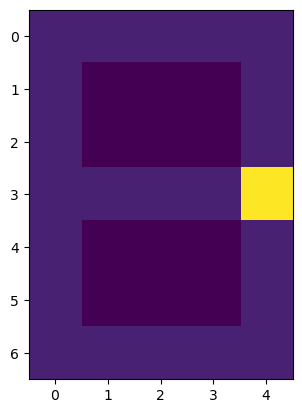

tensor(3)


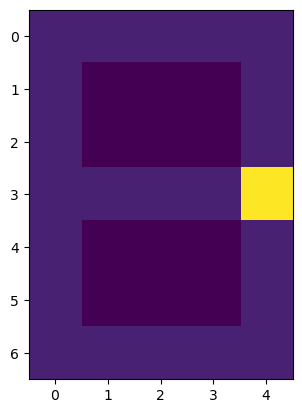

tensor(3)


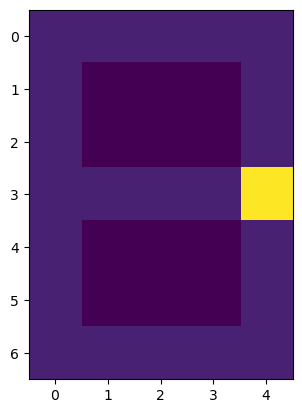

tensor(3)


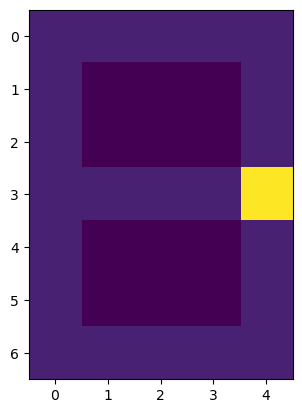

tensor(3)


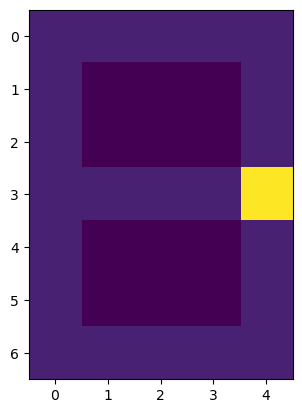

tensor(3)


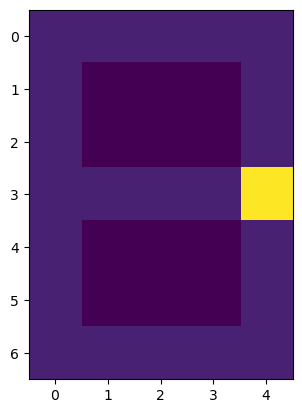

tensor(3)


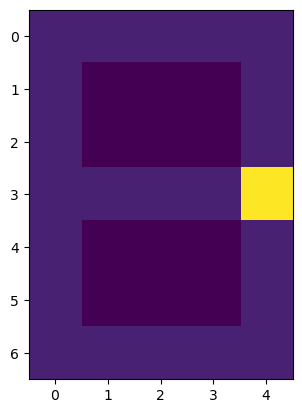

tensor(3)


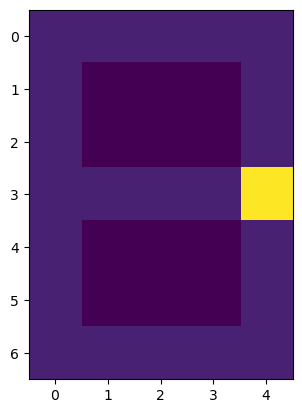

tensor(3)


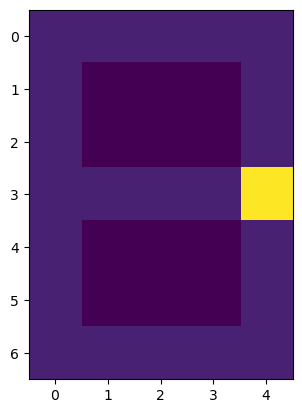

tensor(3)


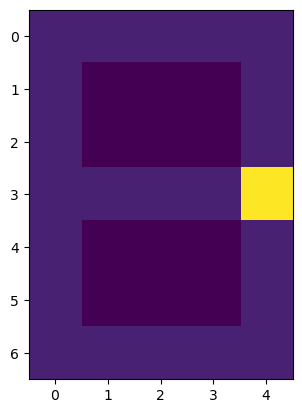

tensor(3)


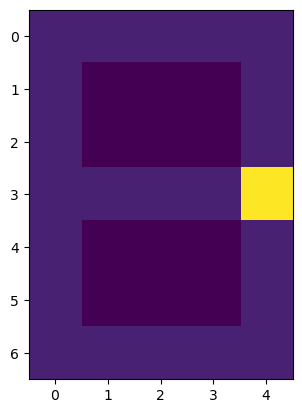

tensor(3)


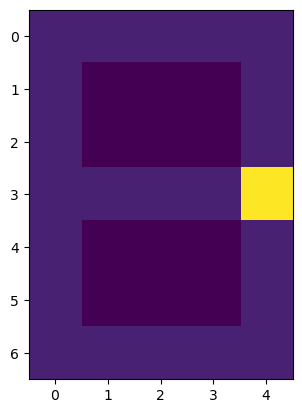

tensor(3)


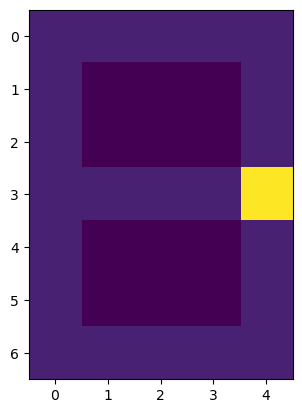

tensor(3)


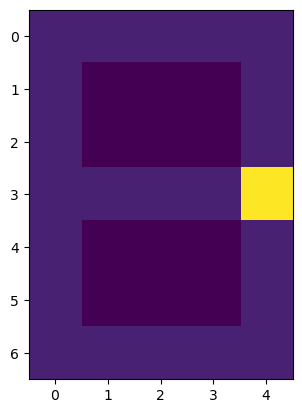

tensor(3)


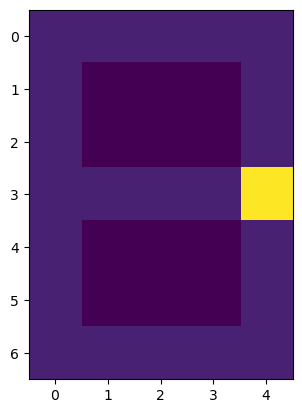

tensor(3)


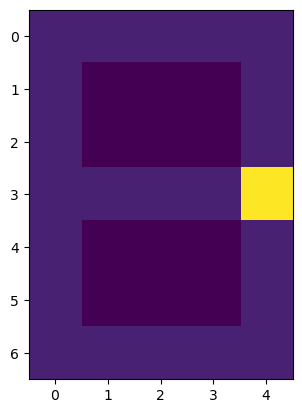

tensor(3)


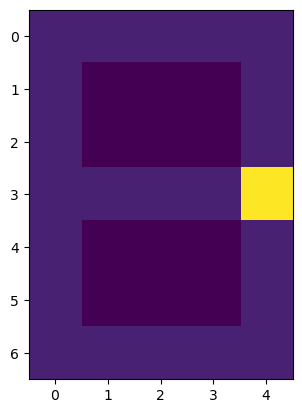

tensor(3)


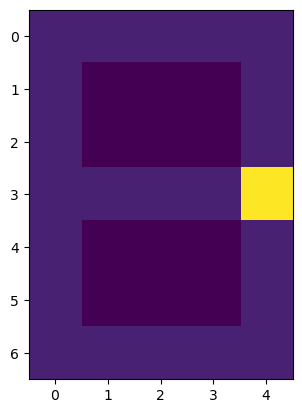

tensor(3)


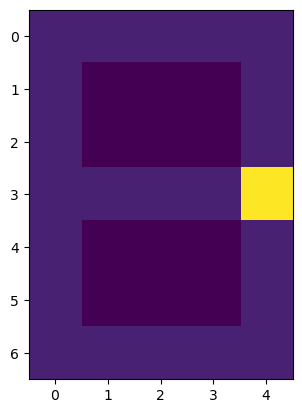

tensor(3)


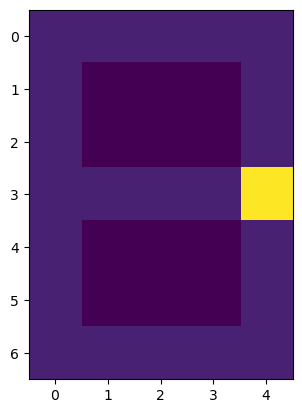

tensor(3)


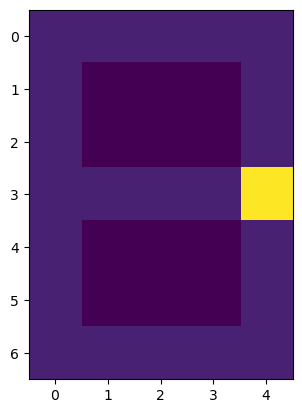

tensor(3)


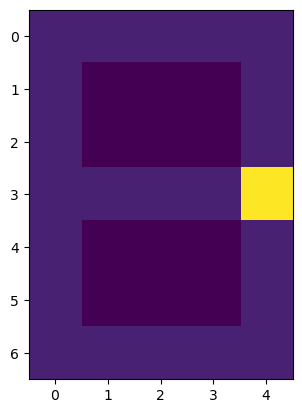

tensor(3)


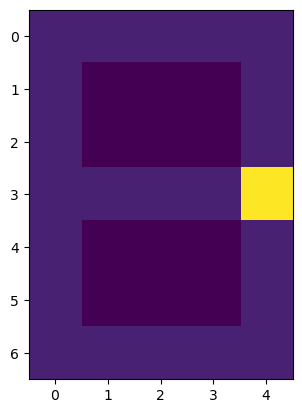

tensor(3)


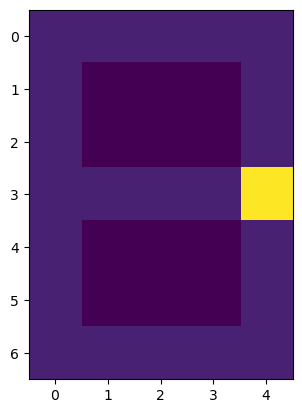

tensor(3)


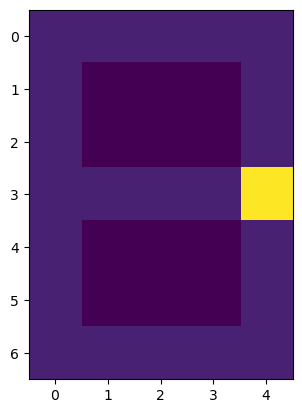

tensor(3)


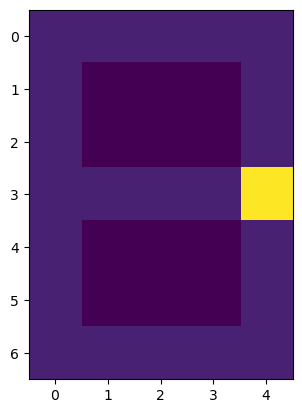

tensor(3)


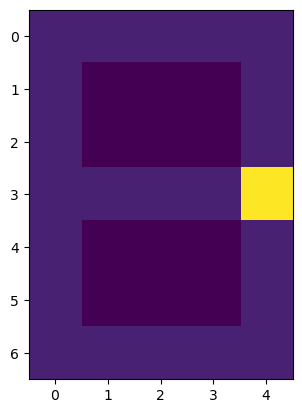

tensor(3)


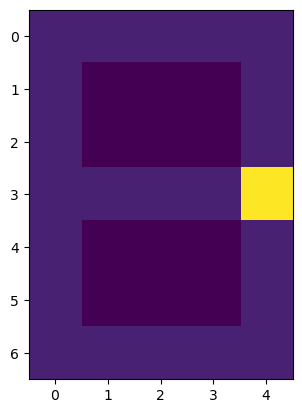

tensor(3)


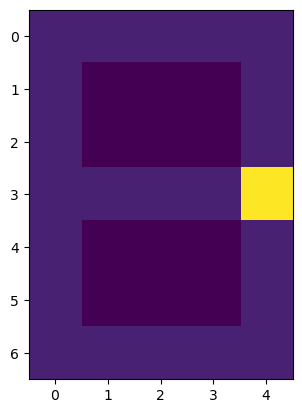

tensor(3)


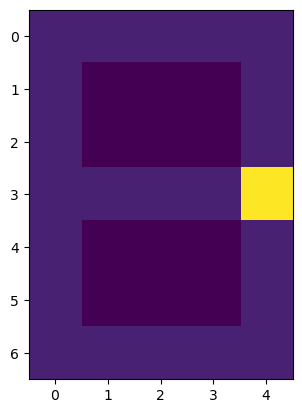

tensor(3)


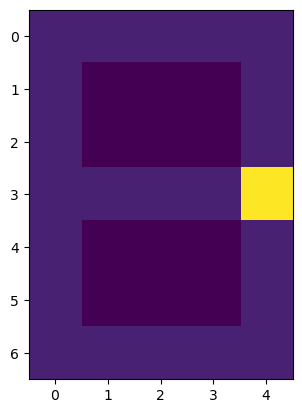

tensor(3)


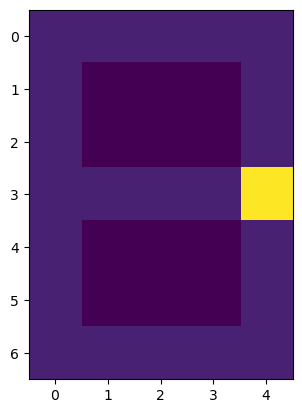

tensor(3)


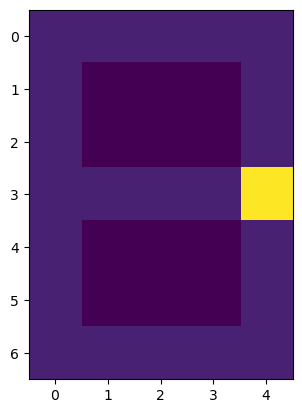

tensor(3)


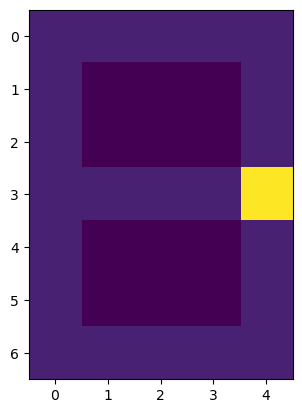

tensor(3)


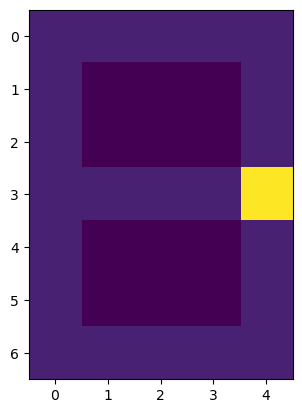

tensor(3)


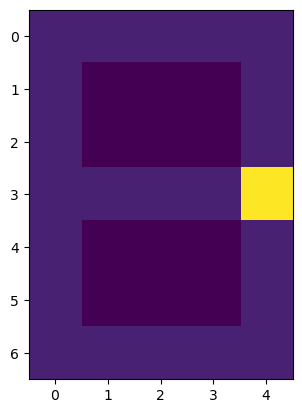

tensor(3)


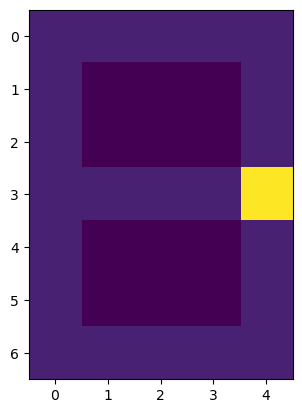

tensor(3)


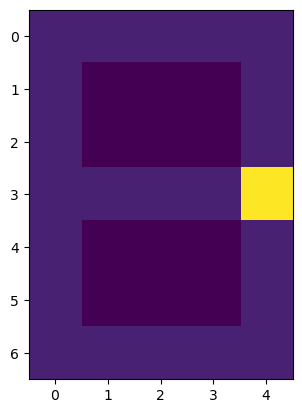

tensor(3)


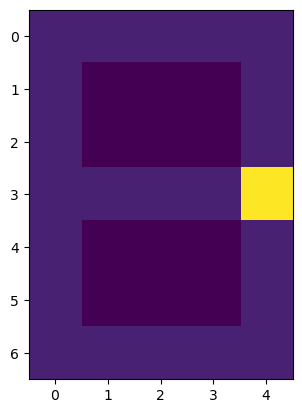

tensor(3)


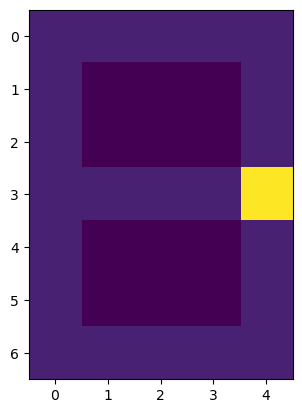

tensor(3)


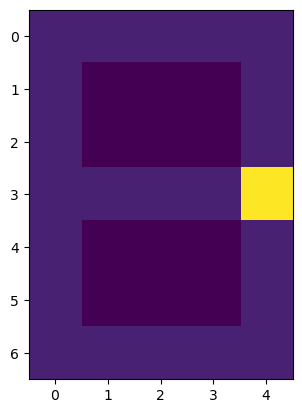

tensor(3)


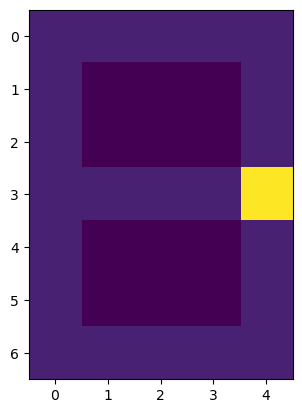

tensor(3)


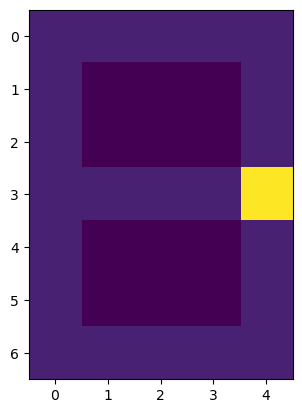

tensor(3)


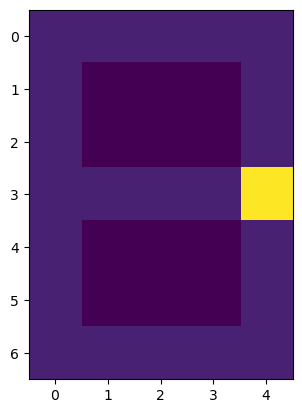

tensor(3)


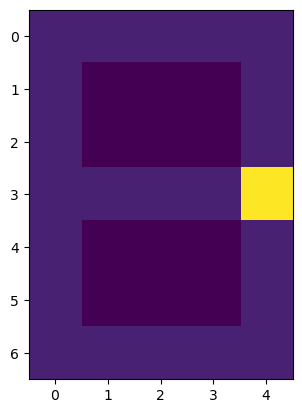

tensor(3)


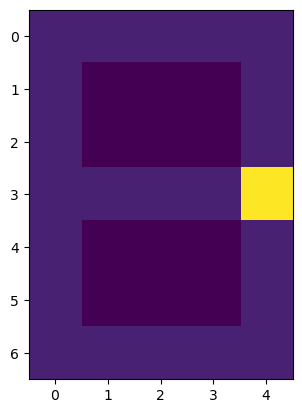

tensor(3)


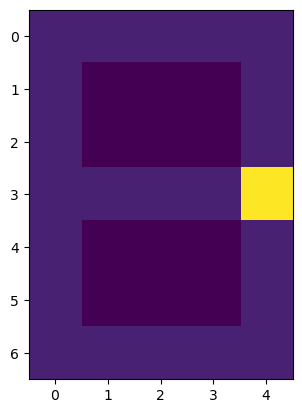

tensor(3)


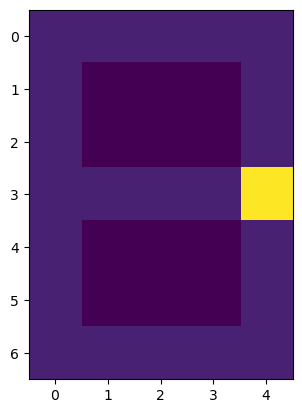

tensor(3)


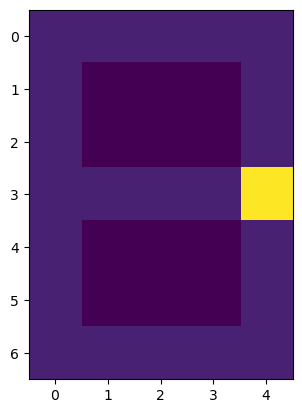

tensor(3)


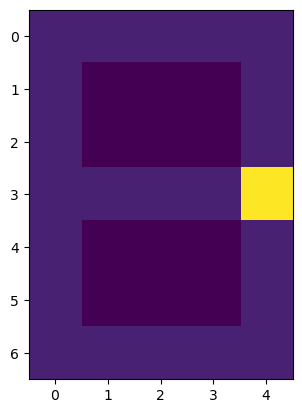

tensor(3)


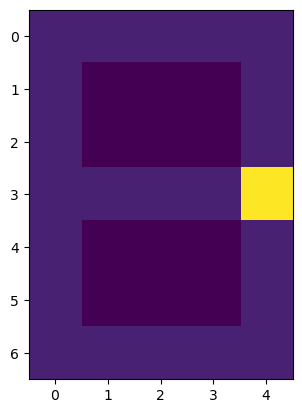

tensor(3)


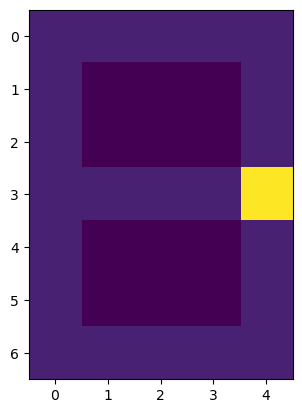

tensor(3)


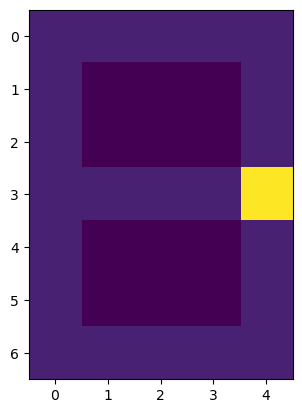

tensor(3)


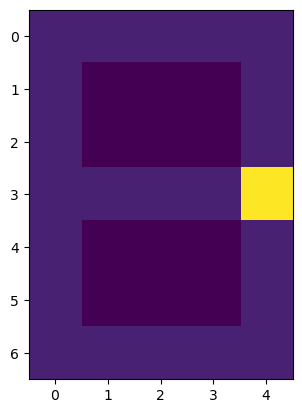

tensor(3)


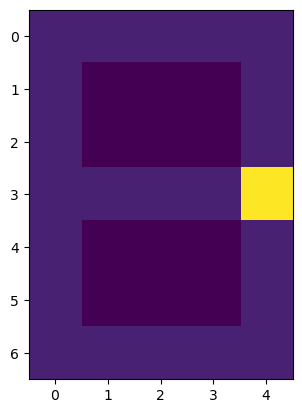

tensor(3)


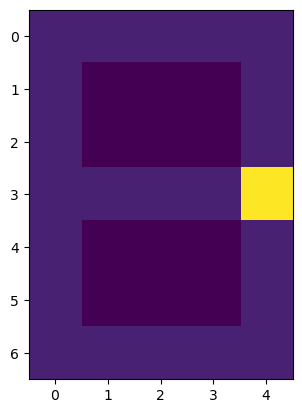

tensor(3)


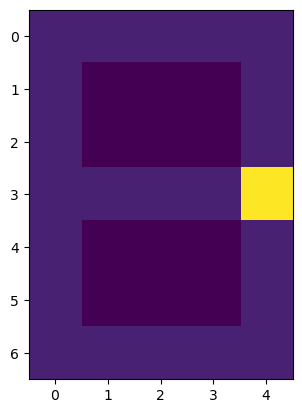

tensor(3)


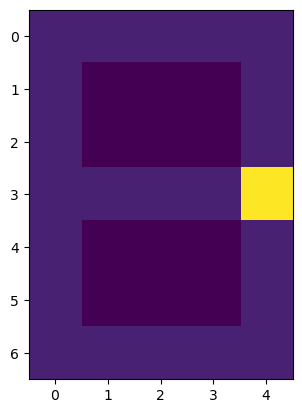

tensor(3)


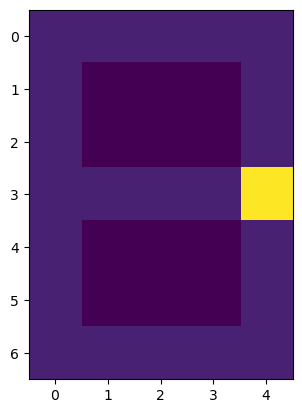

tensor(3)


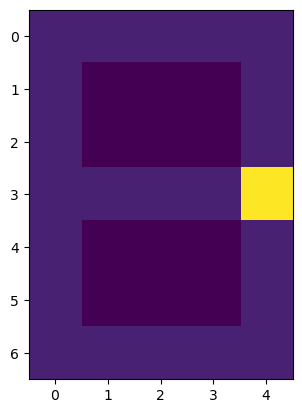

tensor(3)


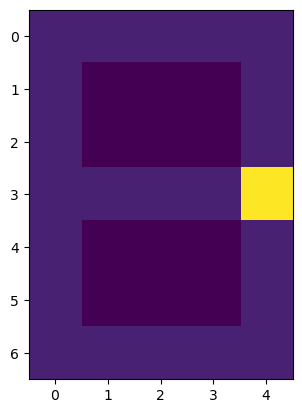

tensor(3)


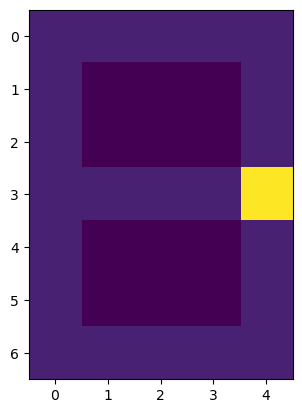

tensor(3)


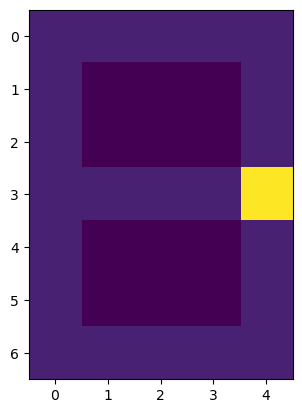

tensor(3)


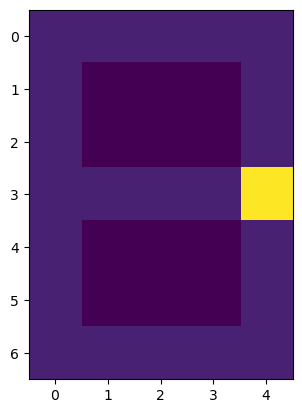

tensor(3)


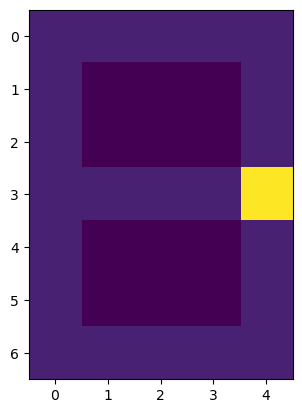

tensor(3)


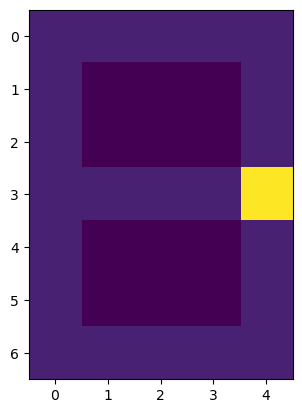

tensor(3)


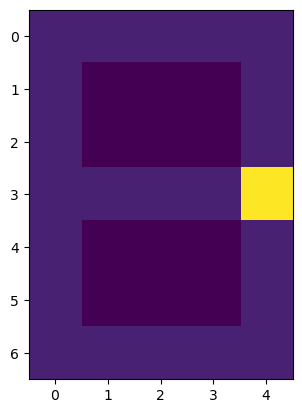

tensor(3)


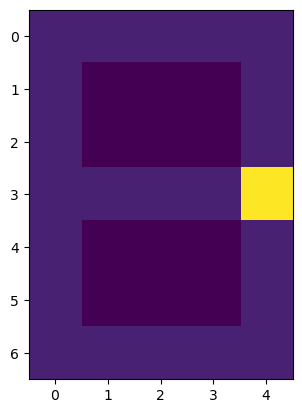

tensor(3)


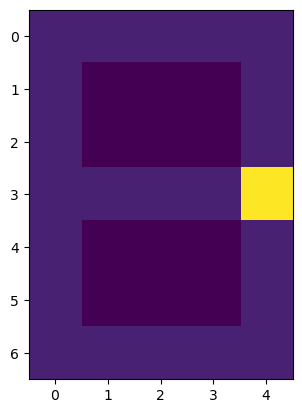

tensor(3)


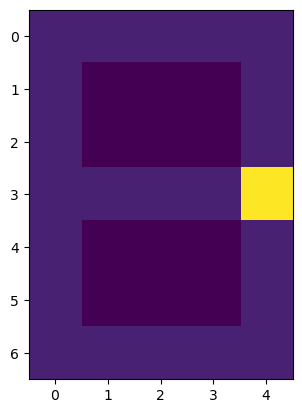

tensor(3)


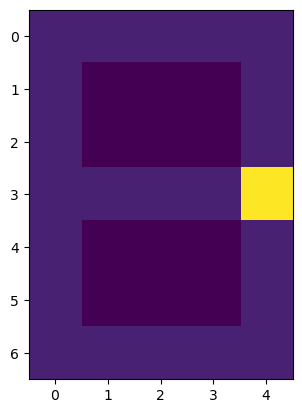

tensor(3)


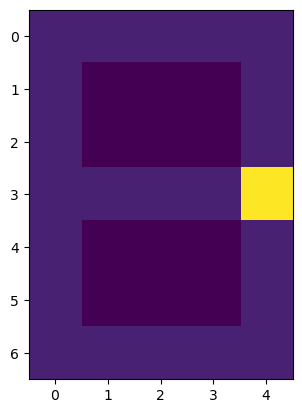

tensor(3)


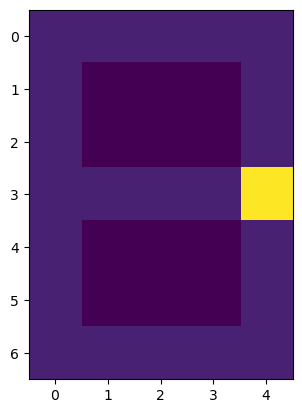

tensor(3)


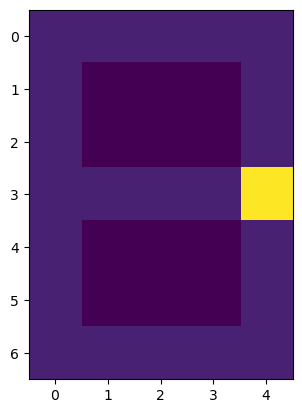

tensor(3)


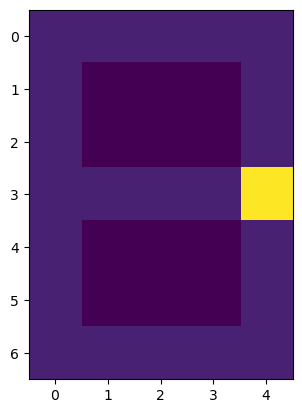

tensor(3)


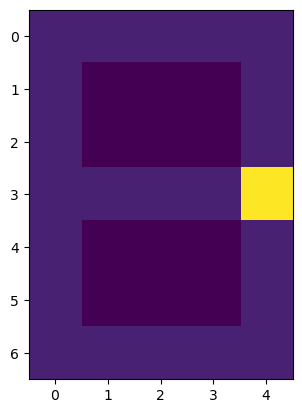

tensor(3)


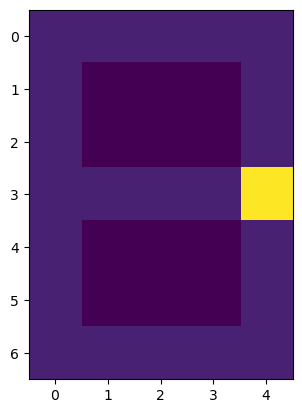

tensor(3)


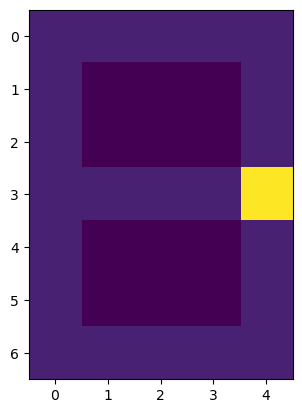

tensor(3)


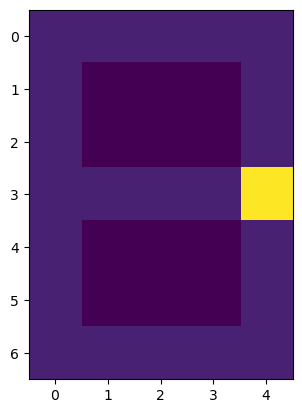

tensor(3)


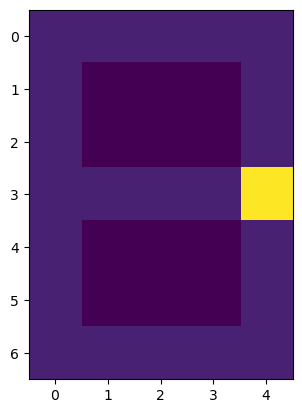

tensor(3)


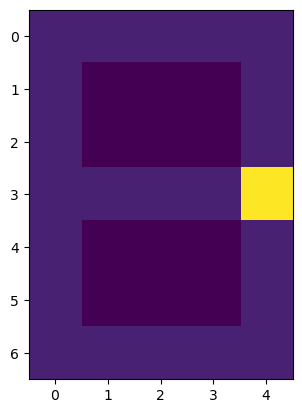

tensor(3)


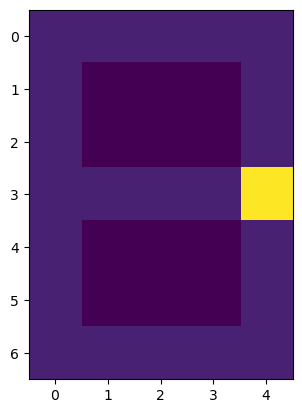

tensor(3)


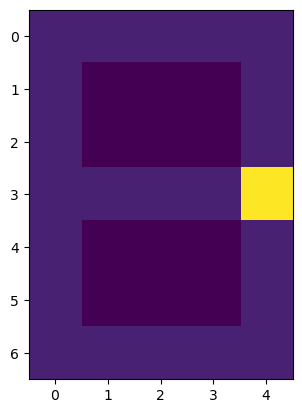

tensor(3)


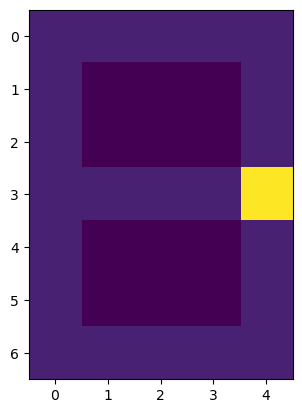

tensor(3)


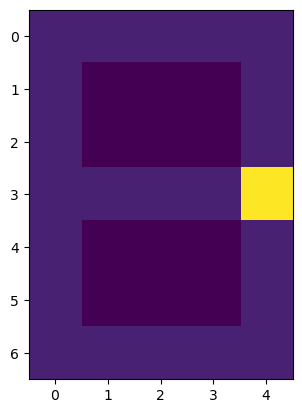

tensor(3)


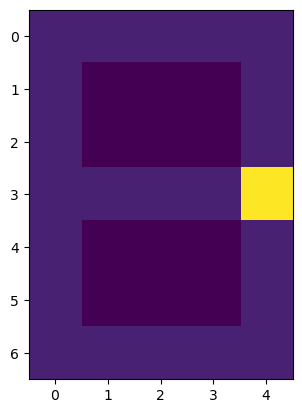

tensor(3)


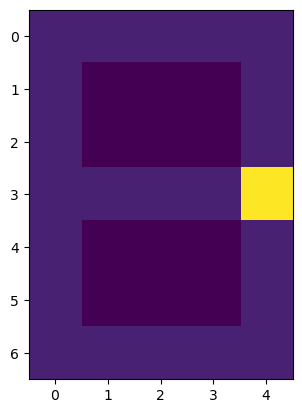

tensor(3)


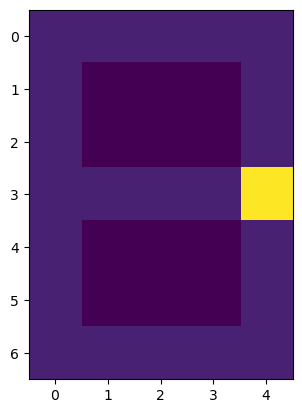

tensor(3)


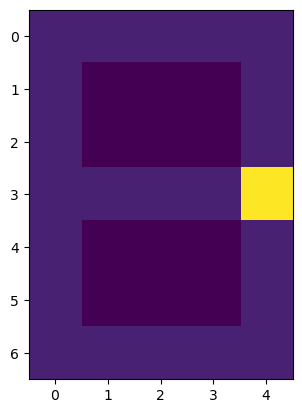

tensor(3)


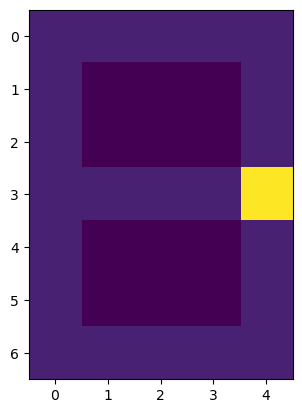

tensor(3)


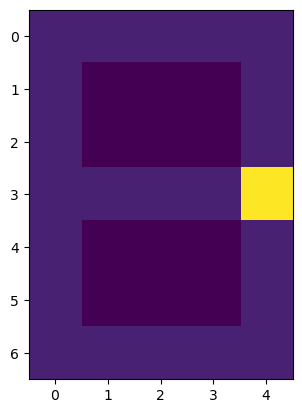

tensor(3)


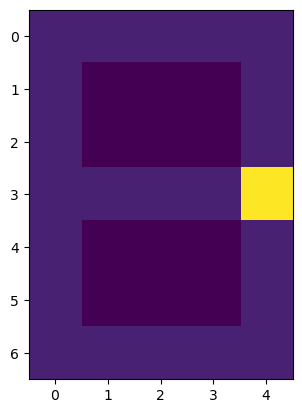

tensor(3)


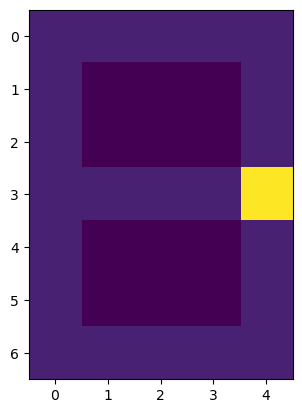

tensor(3)


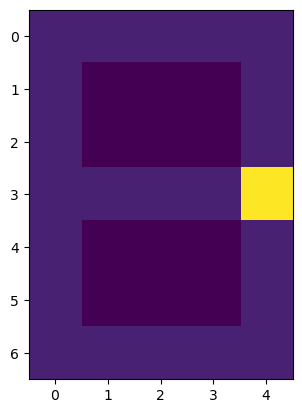

tensor(3)


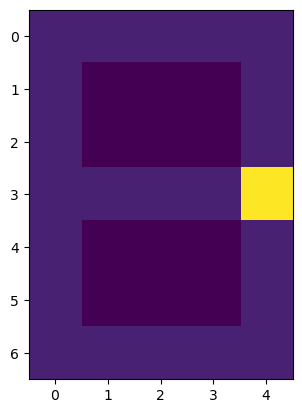

tensor(3)


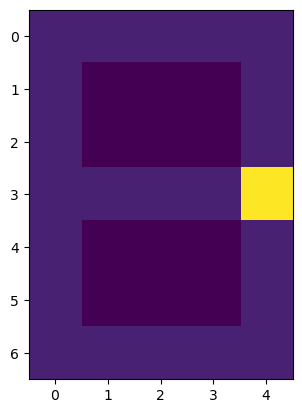

tensor(3)


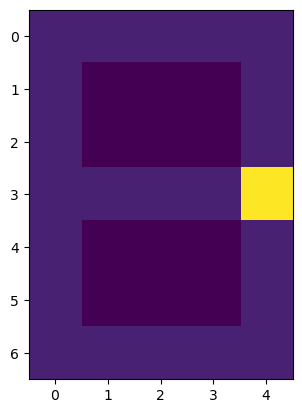

tensor(3)


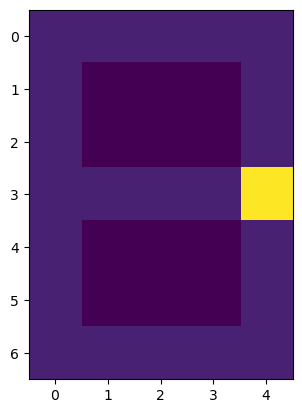

tensor(3)


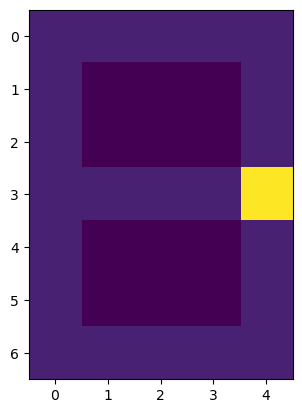

tensor(3)


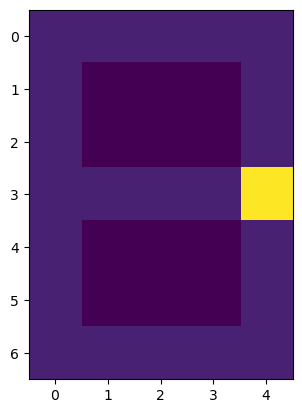

tensor(3)


In [9]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break

### As animation

<IPython.core.display.Javascript object>


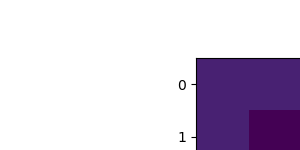

In [10]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
obs = env.observe()
_obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
_obs = np.flip(_obs.squeeze())
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros(_obs.shape))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    _obs = np.flip(_obs.squeeze())
    im = ax.imshow(_obs)
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
        V, action, reward, _ = agent._step()
        agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=100, blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior.gif', writer="ffmpeg", fps = 15)
fig.show()